In [1]:
import os
import os.path as osp
import glob 


WORKING_DIR = '/home/ntphat/projects/medico/medico'
os.chdir(WORKING_DIR)

DATA_DIR = 'data'
coco_annot = osp.join(DATA_DIR, 'coco_annotation.json')

## Inference

In [6]:
import warnings
warnings.filterwarnings("ignore")

from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
import model.ResUnet.dataset as dataset
from model.ResUnet.utils import metrics
from model.ResUnet.core.res_unet import ResUnet
from model.ResUnet.core.res_unet_plus import ResUnetPlusPlus
import torch
import argparse
import os
import os.path as osp
from model.ResUnet.utils import (
    get_parser,get_default_config,BCEDiceLoss,MetricTracker,jaccard_index,dice_coeff,MyWriter,
)
from model.ResUnet.init_config import setup
from model.ResUnet.utils.visualize import visualize_validation
from model.ResUnet.utils import augmentation as aug

from model.ResUnet.init_config import setup
import numpy as np

def draw_mask(image, mask, thres=0.5, alpha=0.5, raw_shape=None):
    if len(mask.shape) == 3:
        mask = mask.squeeze(2)
    mask[mask < thres] = 0.0
    
    if raw_shape is not None:
        # image = cv2.resize(image, dsize=(raw_shape['width'], raw_shape['height']))
        np2pil = transforms.ToPILImage()
        pil_mask = transforms.Resize((raw_shape['height'], raw_shape['width']), Image.NEAREST)(np2pil(mask))
        mask = np.array(pil_mask)
        # mask = cv2.resize(mask, dsize=(raw_shape['width'], raw_shape['height']))

    image = image.copy()
    image[np.nonzero(mask)] = image[np.nonzero(mask)]*alpha + (1-alpha)*np.array([0,0,255], dtype=np.float)
    return image


checkpoint_dir = osp.join(WORKING_DIR, 'result/resunet++/checkpoints')
cfg = get_default_config()
cfg.merge_from_file('src/model/ResUnet/configs/default_resunet.yaml')

str_cfg = cfg.dump()
print(str_cfg)

CHECKPOINT_PATH: ''
DATA:
  ROOT_DIR: ./data
  TEST_IMAGES: test_images
  TRAIN: train4.csv
  TRAIN_IMAGES: train_images
  TRAIN_MASKS: masks
  VAL: val4.csv
INFERENCE:
  BATCH_SIZE: 10
  MASK_THRES: 0.5
  SAVE_DIR: ./result/resunet++/Oct10_5
MODEL:
  IMAGE_SIZE:
  - 448
  - 448
  NAME: res_unet_plus
OUTPUT_DIR: ./result/resunet++/Oct10_5
SOLVER:
  BATCH_SIZE: 4
  EARLY_STOPPING: -1
  EPOCH: 200
  LOGGING_STEP: 10
  LR: 0.001
  VALIDATION_EVERY: -1



In [109]:
from model.ResUnet.convcrf import convcrf

def setup_convcrf(cfg):
    config  = convcrf.get_default_conf()
    num_classes = 1
    config['filter_size'] = 11
    config['pyinn'] = False
    
    config['col_feats']['schan'] = 0.1 # as we are using normalized images
    shape = cfg.MODEL.IMAGE_SIZE

    model = convcrf.GaussCRF(conf=config, shape=shape, nclasses=num_classes)
    model.cuda()

    return model

def apply_convcrf(crf_model, images, preds):
    '''
    Args:
        images: torch tensor in shape of [batch, 3, H, W]
        preds: predicted masks in shape of [batch, 1, H, W]
    
    Return:
        output: refined masks in shape of [batch, 1, H, W]
    '''        
    output = crf_model.forward(unary=preds, img=images)
    return output 

def unnormalize_image(img_tensor):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    data = img_tensor.clone()
    for i, tensor in enumerate(data):
        for j, (t, m, s) in enumerate(zip(tensor, mean, std)):
            tensor[j] = (t.mul_(s).add_(m) - 0.5)/0.2
        
        data[i] = tensor
        
    return data


## pydensecrf
[github](https://github.com/lucasb-eyer/pydensecrf)

In [157]:
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral

def apply_crf(ori_image, mask, mask_thres=0.2):
    """ Conditional Random Field
    ori_image: np.array with value between 0-255
    mask: np.array with value between 0-1
    """

    ## Grayscale to RGB
#     if len(mask.shape) < 3:
#     mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
#     print(np.max(mask))
#     print(np.min(mask))        

    ## Converting the anotations RGB to single 32  bit color
    mask[mask > mask_thres] = 1.0
    annotated_label = mask.astype(np.int32)
    # annotated_label = mask[:,:,0] + (mask[:,:,1]<<8) + (mask[:,:,2]<<16)

    ## Convert the 32bit integer color to 0,1, 2, ... labels.
    colors, labels = np.unique(annotated_label, return_inverse=True)
    n_labels = 2

    ## Setting up the CRF model
    d = dcrf.DenseCRF2D(ori_image.shape[1], ori_image.shape[0], n_labels)

    ## Get unary potentials (neg log probability)
    U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=False)
    d.setUnaryEnergy(U)

    ## This adds the color-independent term, features are the locations only.
    d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

    ## Run Inference for 10 steps
    Q = d.inference(10)

    ## Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)

    return MAP.reshape((ori_image.shape[0], ori_image.shape[1]))

## Inference

In [110]:
checkpoint_dir = osp.join(WORKING_DIR, 'result/resunet++/checkpoints')
cfg = get_default_config()
cfg.merge_from_file('src/model/ResUnet/configs/default_resunet.yaml')

batch_size = 2

image_transforms, label_transforms = aug.create_transform(cfg, 'val')
dataset_val = dataset.ImageDataset(
    cfg, 
    img_path=osp.join(cfg.DATA.ROOT_DIR, cfg.DATA.TRAIN_IMAGES),  
    mask_path=osp.join(cfg.DATA.ROOT_DIR, cfg.DATA.TRAIN_MASKS),
    train=False,
    image_transform=transforms.Compose(image_transforms),
    label_transform=transforms.Compose(label_transforms),
)
val_dataloader = DataLoader(dataset_val, batch_size=batch_size, num_workers=4, shuffle=False)


val_tracker = metrics.ValidationTracker()

# Load checkpoint
model = ResUnetPlusPlus(3).cuda()

resume = osp.join(checkpoint_dir, 'best_model.pt')
checkpoint = torch.load(resume)
model.load_state_dict(checkpoint['state_dict'])
print(f"LOADED MODEL SUCCESSFULLY")

visualization_save_dir = osp.join(cfg.INFERENCE.SAVE_DIR, 'visualize_val')
os.makedirs(visualization_save_dir, exist_ok=True)

crf_model = setup_convcrf(cfg)

sample_img, sample_label, pred_mask, crf_mask, crf_label = None, None, None, None, None
# do inference
model.eval()
with torch.no_grad():
    for idx, data in tqdm(enumerate(val_dataloader)):
        inputs = data['sat_img'].cuda()
        labels = data['map_img'].cuda()

        # print(data['raw_shape'])
        img_paths, raw_shape = data['image_path'], data['raw_shape']

        outputs = model(inputs)
        all_scores = metrics.calculate_all_metrics(outputs, labels)
        img_names = [p.strip().split('/')[-1] for p in img_paths]
        save_paths = [osp.join(visualization_save_dir, p) for p in img_names]
        
        unnormalized_imgs = unnormalize_image(inputs)
        print(f"output shape: {outputs.shape}")
        print(f"labels shape: {labels.shape}")    
    
        crf_preds = apply_convcrf(crf_model, unnormalized_imgs, outputs*255.0)
        feed_labels = labels.unsqueeze(1)
        crf_labels = apply_convcrf(crf_model, unnormalized_imgs, feed_labels*255.0)
        
        print(f"inputs max: {torch.max(inputs)}, inputs min: {torch.min(inputs)}")
        print(f"crf_inputs max: {torch.max(unnormalized_imgs)}, crf_inputs min: {torch.min(unnormalized_imgs)}")
        print(f"crf_preds max: {torch.max(crf_preds)}, crf_preds min: {torch.min(crf_preds)}")
        print(f"outputs max: {torch.max(outputs)}, outputs min: {torch.min(outputs)}")
        
        sample_img = inputs[0].permute(1, 2, 0).cpu().numpy()
        pred_mask = outputs[0].permute(1, 2, 0).cpu().numpy()
        sample_label = feed_labels[0].permute(1, 2, 0).cpu().numpy()
        crf_mask = crf_preds.data[0].permute(1, 2, 0).cpu().numpy()
        crf_label = crf_labels.data[0].permute(1, 2, 0).cpu().numpy()
        break


#         imgs = inputs.cpu().permute(0, 2, 3, 1).numpy()
#         gts = labels.cpu().numpy()
#         preds = outputs.cpu().permute(0, 2, 3, 1).numpy()

#         val_tracker.update(all_scores)
#         visualize_validation(img_paths, gts, preds, save_paths, all_scores, cfg, raw_shape)

#     val_tracker.to_json(osp.join(cfg.INFERENCE.SAVE_DIR, 'scores.json'))



Created dataset with 200 images
LOADED MODEL SUCCESSFULLY


0it [00:00, ?it/s]

output shape: torch.Size([2, 1, 448, 448])
labels shape: torch.Size([2, 448, 448])
inputs max: 2.640000104904175, inputs min: -2.1179039478302
crf_inputs max: 2.5, crf_inputs min: -2.5
crf_preds max: 244.12071228027344, crf_preds min: 3.624372959136963
outputs max: 1.0, outputs min: 0.0


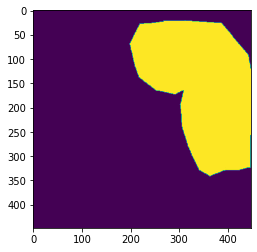

In [111]:
plt.imshow(sample_label)

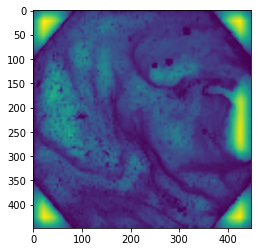

In [112]:
plt.imshow(crf_label/255.0)

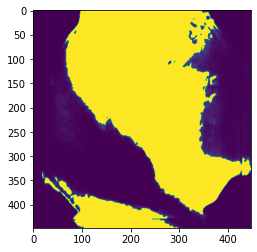

In [158]:
import matplotlib.pyplot as plt 

plt.imshow(pred_mask)

In [159]:
print(sample_img.shape)
print(pred_mask.shape)

(448, 448, 3)
(448, 448, 1)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


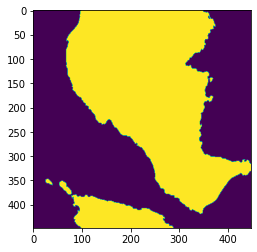

In [160]:
new_mask = apply_crf(sample_img, pred_mask, mask_thres=0.7)
print(new_mask)
plt.imshow(new_mask)

2020-10-12 14:35:15,626 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


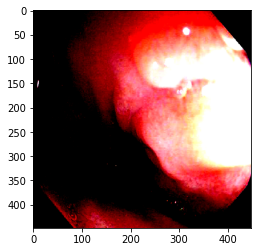

In [23]:
plt.imshow(sample_img)

2020-10-12 14:36:48,963 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


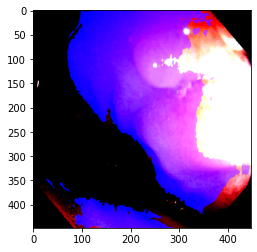

In [27]:
plt.imshow(draw_mask(sample_img, pred_mask))

2020-10-12 14:37:39,336 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


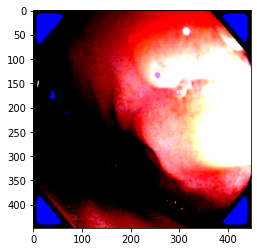

In [32]:
plt.imshow(draw_mask(sample_img, crf_mask/255.0, thres=0.3))

In [46]:
import cv2 
from PIL import Image
test_img = 'data/train_images/cju0qkwl35piu0993l0dewei2.jpg'
tmp = Image.open(test_img)
np_tmp = np.array(tmp)
print(np.max(np_tmp))
print(np.min(np_tmp))

255
0


In [56]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

image_trans = [
            transforms.Resize((448,448), Image.NEAREST),
            transforms.ToTensor(),
            transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
        ]
trans = transforms.Compose(image_trans)

In [57]:
tran_tmp = trans(tmp)
np_tmp = np.array(tran_tmp)
print(np.max(np_tmp))
print(np.min(np_tmp))

2.64
-2.117904


In [58]:
print(torch.max(tran_tmp))
print(torch.min(tran_tmp))

tensor(2.6400)
tensor(-2.1179)


In [ ]:
!pip install 